##### [2021-11-02] [PT] Planter code Testing.
    good to run!
    
#### [2021-11-03] check with fixed random_state=42


#### [2021-11-05] 

     
#### [2021-11-06] test multiple models

#### [2021-11-07] (1)Test W/WO Aug. (2) model.trainable=True. (3)Test tl with training=false.

    
        
            



# 101 Course of transfer learning and Fine tune 2021-01-01

## Intro
## Foot_Plantar_Pressure_Points

/Users/lsw/work.Local/TF2_books_code_test/course_2020/Foot_Plantar_Pressure_Points

todo: move to note.py


## import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf






In [ ]:
# !sh ../install_env.sh

In [2]:
# %reset -f

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer


from pytictoc import TicToc

t = TicToc() #create instance of class

t.tic() #Start time

In [4]:
print(tf.__version__)
print(cv2.__version__)

2.5.0
4.5.3


### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [5]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [6]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [7]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [8]:

# data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'



# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# df[1335:]



# data-train #
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'



# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'

# # data-train-HPL-1223
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'

df = pd.read_csv(ann)
df[:10]

,images,x1,y1,x2,y2
0,image_0001.png,55,136,75,383
1,image_0002.png,62,139,42,385
2,image_0003.png,47,117,76,368
3,image_0004.png,66,119,37,376
4,image_0005.png,58,147,85,381
5,image_0006.png,56,147,29,383
6,image_0007.png,52,120,67,368
7,image_0008.png,62,121,38,375
8,image_0009.png,72,159,78,385
9,image_0010.png,60,149,33,385


In [9]:
len(df)

1345

#### Shuffle and reset index

In [10]:
# reset index
# df = df.sample(frac=1).reset_index(drop=True)

# fixed shuffle for compare, random_state=42
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [11]:
df.head(10)

,images,x1,y1,x2,y2
0,image_0299.png,50,103,73,383
1,image_0274.png,50,154,27,369
2,image_6298.jpg,61,153,35,384
3,image_0218.jpg,52,138,79,381
4,image_0231.png,60,109,24,384
5,image_0841.png,67,113,30,374
6,image_0873.png,54,155,24,381
7,image_0168.jpg,60,119,31,380
8,image_6331.jpg,69,131,79,385
9,image_0078.png,63,104,19,378


See, the image_####.jpg now are random.

In [12]:
# fixed 1424 shuffle for compare, random_state=42
# 
# 0	image_6186.jpg	59	139	39	386
# 1	image_0678.png	60	138	78	384
# 2	image_6085.png	68	142	83	381
# 3	image_6006.png	63	120	32	386
# 4	image_0945.png	64	132	31	370
# 5	image_0539.png	63	160	39	366
# 6	image_0995.png	54	150	37	376
# 7	image_0725.png	49	136	32	383
# 8	image_0071.png	51	134	70	385
# 9	image_0124.png	65	136	33	384

In [13]:
# fixed 1345 shuffle for compare, random_state=42

# 0	image_0299.png	50	103	73	383
# 1	image_0274.png	50	154	27	369
# 2	image_6298.jpg	61	153	35	384
# 3	image_0218.jpg	52	138	79	381
# 4	image_0231.png	60	109	24	384
# 5	image_0841.png	67	113	30	374
# 6	image_0873.png	54	155	24	381
# 7	image_0168.jpg	60	119	31	380
# 8	image_6331.jpg	69	131	79	385
# 9	image_0078.png	63	104	19	378

#### Create tf.dataset (DS)

In [14]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [15]:
# len(list_ds)#.shape() #take(1)

In [16]:
# # check The type specification of an element of this dataset.
# list_ds.element_spec


In [17]:
# for f,x1,y1,x2,y2 in list_ds.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

In [18]:
# # use np decode to UTF-8
# print(f.numpy().decode('UTF-8'))

In [19]:
# len(list_ds)

#### Check ds iterator for consuming

In [20]:
# # create a Python iterator

# it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [21]:
# # using iter and consuming its elements using next: every print different image name.

# for i in range(4):
#     image, x1, y1, x2, y2 = next(it_list_ds)
#     print(image.numpy(), x1.numpy(), y1.numpy())

In [22]:
# # image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# # pred = model.predict_on_batch(image_batch)


# for i in range(4):
#     image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
#     print(image, x1, y1, x2, y2)
    
# iter_test_list = list_ds.as_numpy_iterator()
# print("===== Create iterator once and pull out to above cell. =====")
# for i in range(4):
#     image, x1, y1, x2, y2 = iter_test_list.next()
#     print(image, x1, y1, x2, y2)


#### Process path to image tensor in DS

In [23]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [24]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [25]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

# for img, [x, y] in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('f', f.dtype)
# print('x', x.dtype)

In [26]:
# x

In [27]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

In [28]:
# split Toe
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

print(len(train_ds_map_toe))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

1345
269
1076
269


In [29]:
# split Heel
val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

print(len(train_ds_map_heel))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

1345
269
1076


# new split TVT train/val/test

In [30]:
# TVT ratio 0.7:0.15:0.15

In [31]:
# test_list_ds = tf.data.Dataset.from_tensor_slices(range(20))

# # for ele in test_list_ds:
# #     print(ele)

    
# val_size = int(tf.data.experimental.cardinality(test_list_ds).numpy() * 0.15)
# print(" val_size:", val_size)    
    
# print("Train")
# for ele in test_list_ds.skip(val_size*2):
#     print('skip', ele)

# print("temp_take")    
# temp_take_list_ds = test_list_ds.take(val_size*2)

# print("val")
# for ele in temp_take_list_ds.take(val_size):
#     print('take', ele)

# print("Test")
# for ele in temp_take_list_ds.skip(val_size):
#     print('take', ele)


In [32]:
# # split Toe TVT train/val/test


# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.15)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# print(" val_size:", val_size)

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size+val_size)
# temp_tdmt_s = train_ds_map_toe.take(val_size+val_size)

# valid_ds_map_toe_s = temp_tdmt_s.take(val_size)
# test_ds_map_toe_s = temp_tdmt_s.skip(val_size)

# print(len(train_ds_map_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(test_ds_map_toe_s).numpy())

In [33]:
# # split Heel TVT train/val/test


# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.15)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)
# print(" val_size:", val_size)

# train_ds_map_heel_s = train_ds_map_heel.skip(val_size+val_size)
# temp_tdmh_s = train_ds_map_heel.take(val_size+val_size)

# valid_ds_map_heel_s = temp_tdmh_s.take(val_size)
# test_ds_map_heel_s = temp_tdmh_s.skip(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(test_ds_map_heel_s).numpy())

# Albumentation pipeline

In [34]:

# # for NO keypoint augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label








# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA (alpha=0.1, always_apply=False, p=1),
            A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
            A.HorizontalFlip(p=0.5),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
            )



# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)]
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
#     print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

#     print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])
#     print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(keypoints, [2,]) # for 'tf ds tarining'
#     print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 


def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


#### prepare train_ds_prefetch

In [35]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [36]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [37]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# Toe ds_pre
train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=False) #True False
valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# test_ds_pre_toe_s = configure_for_performance_cache_val(test_ds_map_toe_s)



# Heel ds_pre
train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=False) #True
valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

# test_ds_pre_heel_s = configure_for_performance_cache_val(test_ds_map_heel_s)

Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]


#### Check ds_prefetch samples

In [38]:
# create it_ds once
it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
 [min,max]: 3 255
Check lables: [42 53]
 [min,max]: 0 255
Check lables: [47 54]
 [min,max]: 0 255
Check lables: [62 43]
 [min,max]: 3 255
Check lables: [59 67]
 [min,max]: 0 255
Check lables: [62 41]
 [min,max]: 4 255
Check lables: [73 53]
 [min,max]: 0 255
Check lables: [60 44]
 [min,max]: 0 255
Check lables: [72 79]
 [min,max]: 0 255
Check lables: [64 51]
 [min,max]: 0 255
Check lables: [57 39]
 [min,max]: 3 255
Check lables: [74 36]


/home/u3148947/.local/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


 [min,max]: 1 255
Check lables: [65 40]
 [min,max]: 3 255
Check lables: [60 43]
 [min,max]: 0 255
Check lables: [54 59]
 [min,max]: 0 255
Check lables: [60 56]
 [min,max]: 0 255
Check lables: [58 39]
CPU times: user 1.88 s, sys: 219 ms, total: 2.1 s
Wall time: 4.13 s


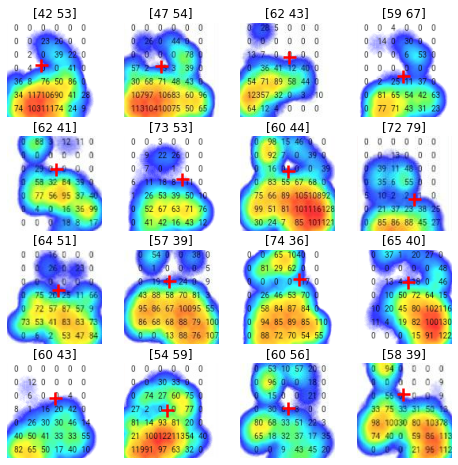

In [39]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_toe_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    
    # 2021-11-05
    # Check jpg, png agter ds is [0-255]
    print(' [min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max())
    
    
    
    print(f'Check lables: {label_batch[i]}')


In [40]:
# create it_ds once
it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [ 25 102]
Check lables: [ 80 103]
Check lables: [ 20 101]
Check lables: [70 92]
Check lables: [ 80 104]
Check lables: [82 96]
Check lables: [ 38 106]
Check lables: [ 29 105]
Check lables: [ 28 102]
Check lables: [35 89]
Check lables: [ 27 103]
Check lables: [26 91]
Check lables: [ 79 103]
Check lables: [ 80 103]
Check lables: [ 44 103]
Check lables: [71 82]
CPU times: user 1.53 s, sys: 124 ms, total: 1.66 s
Wall time: 716 ms


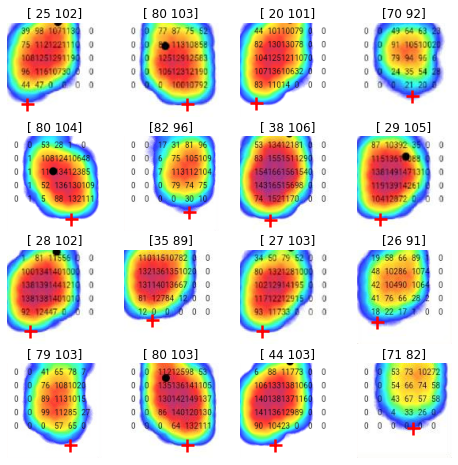

In [41]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_heel_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')

In [42]:
# create it_ds once
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
[min,max]: 0 255
Check lables: [50 23]
[min,max]: 3 255
Check lables: [50 74]
[min,max]: 0 255
Check lables: [61 73]
[min,max]: 0 255
Check lables: [52 58]
[min,max]: 0 255
Check lables: [60 29]
[min,max]: 3 255
Check lables: [67 33]
[min,max]: 3 255
Check lables: [54 75]
[min,max]: 0 255
Check lables: [60 39]
[min,max]: 0 255
Check lables: [69 51]
[min,max]: 0 255
Check lables: [63 24]
[min,max]: 0 255
Check lables: [53 40]
[min,max]: 0 255
Check lables: [59 52]
[min,max]: 3 255
Check lables: [60 54]
[min,max]: 3 255
Check lables: [69 38]
[min,max]: 3 255
Check lables: [57 43]
[min,max]: 0 255
Check lables: [47 26]
CPU times: user 380 ms, sys: 32.5 ms, total: 412 ms
Wall time: 295 ms


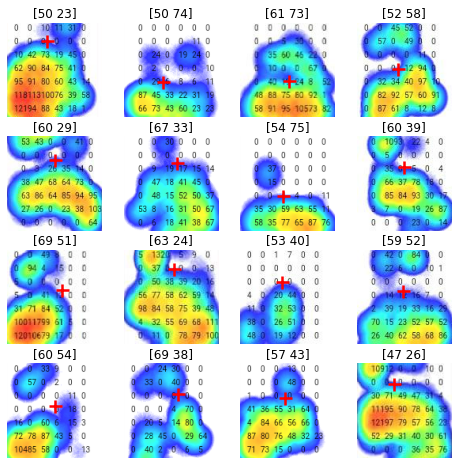

In [43]:
%%time

# for albu keypoint

# for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
image_batch, label_batch = next(it_valid_ds_pre_toe_s)

plt.figure(figsize=(8, 8))
# for images, labels in valid_ds_pre_toe_s.take(1):
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)
    
    # 2021-11-05
    # Check jpg, png agter ds is [0-255]
    print('[min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max())

    print(f'Check lables: {label_batch[i]}')
        

In [44]:
# %%time

# #2021-01-30
# # for change default [x, y] tuple to x, y

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, x, y in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(x[i].numpy(), y[i].numpy(), 'r+', markersize=13, mew=2.5)

In [45]:
# %%time

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'r+', markersize=13, mew=2.5)

In [46]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [47]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [48]:
# %%time

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels))
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(str(labels[i].numpy()))
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'b+', markersize=13, mew=2.5)
# #         print((labels[i].numpy()[0], labels[i].numpy()[1]))

In [49]:
# create it_ds once
# it_train_ds_pre_toe = iter(train_ds_pre_toe_s)

In [50]:
# image_batch, label_batch = next(it_train_ds_pre_toe)

# plt.figure(figsize=(18, 18))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title('x1,y1:' + str(label_batch[i].numpy()))
#     plt.axis("off")
    
#     #print(label_batch[i])
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

### [OLD] Split train_ds_pre

##### train_ds_pre_s
##### valid_ds_pre_s 

### re-set to toe/heel split
##### train_ds_pre_toe_s
##### valid_ds_pre_toe_s

##### train_ds_pre_heel_s
##### valid_ds_pre_heel_s

#### split Toe

In [51]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_toe).numpy() * 0.2)

# train_ds_pre_toe_s = train_ds_pre_toe.skip(val_size)
# valid_ds_pre_toe_s = train_ds_pre_toe.take(val_size)

# print(len(train_ds_pre_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_toe_s).numpy())

#### split Heel

In [52]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_heel).numpy() * 0.2)

# train_ds_pre_heel_s = train_ds_pre_heel.skip(val_size)
# valid_ds_pre_heel_s = train_ds_pre_heel.take(val_size)

# print(len(train_ds_pre_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_heel_s).numpy())

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [53]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [54]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [55]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [56]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [57]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [58]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [59]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [60]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [61]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [62]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [63]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [64]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [65]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [66]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [67]:
# ed_metric_2d_mean(y_true, y_pred).numpy()

In [68]:
# ed_metric_2d_mean(y_true, y_pred)

### Test howto contact the all pred reuslt for submit.CSV

In [69]:
# # append test
# aa= [[ 32.0332  , 105.49409 ],
#        [ 68.21191 ,  83.02111 ],
#        [ 32.07095 ,  99.04422 ]]
# bb= [[ 11.0332  , 22.49409 ],
#        [ 33.21191 ,  44.02111 ]]
# all_pred = np.append(aa, bb, axis=0)#上下接

In [70]:
# all_pred

In [71]:
# all_pred.shape

In [72]:
# all_pred_12 = np.append(all_pred, all_pred, axis=1)#左右接

In [73]:
# all_pred_12

In [74]:
# all_pred_12.shape

# multi output regression model

In [75]:
# from tensorflow import keras 
# from tensorflow.keras import models
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

# model_name = 'simple-Conv2D'

# model = models.Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=(120, 120, 3), activation='relu'))#fix by filters, (ks,ks)
# # model.add(Conv2D(3, 3, input_shape=(120, 120, 3), activation='relu'))# still run
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(32, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(64, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(2))

In [76]:
# ep_num = 1000


In [77]:
# model.compile(optimizer='adam', loss=ed_metric_2d_mean)#, metrics=['mae'])


In [78]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size ot ep_num
#     tf.keras.callbacks.LearningRateScheduler(clr3),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
# #     lr_reduceonplateau,
# #     PrintLRheel()
# ]

In [79]:
# %%time
# # fit the model on all data

# ### re-set to toe/heel split
# ##### train_ds_pre_toe_s
# ##### valid_ds_pre_toe_s
# model.fit(train_ds_pre_toe_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_toe_scallbacks=callbacks)#, validation_split=0.1)

# ##### train_ds_pre_heel_s
# ##### valid_ds_pre_heel_s
# # model.fit(train_ds_pre_heel_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_heel_s)#, validation_split=0.1)


In [80]:
# model.evaluate(valid_ds_pre_toe_s)

In [81]:
# model.evaluate(valid_ds_pre_heel_s)

# EFNE Training

maybe mae better than ed loss?

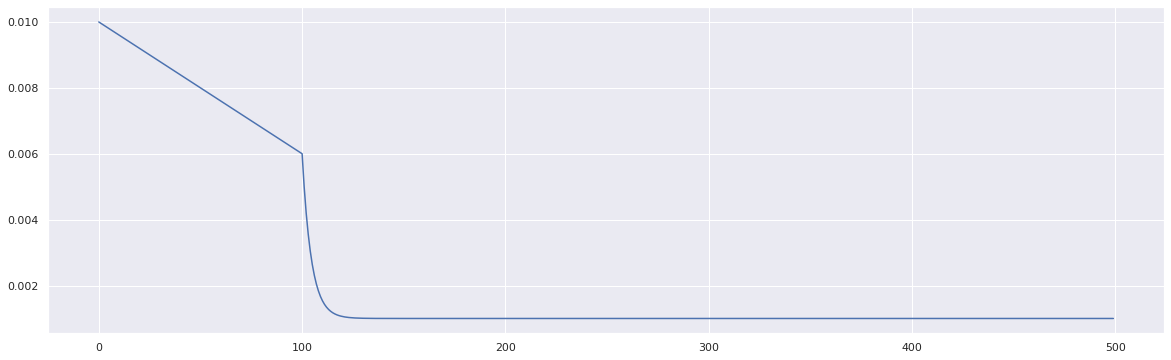

In [82]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [83]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [84]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

In [85]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [86]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [87]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [88]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [89]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [90]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [91]:
model_name = 'EfficientNetB0'

# 2021-11-05 test
# model_name = 'EfficientNetB3'

# model_name = 'EfficientNetB7'


# model_name = 'VGG16'

In [92]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

th = 'toe'
# th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
best_model_name: ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5


In [93]:
""" TensorBoard callback will slowdown the training.
tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs
)
"""

logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [94]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
    PrintLRtoe()
]

In [95]:
# create keras model

# model_name = 'EfficientNetB0'

# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2

# with strategy.scope():
    
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",drop_connect_rate=drop_connect_rate) #{'imagenet', None}

#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(2)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model_toe = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

#     model_toe.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)
#                       #metrics=[tf.keras.metrics.MeanSquaredError()])
#                       #metrics=[edRescal])
    
# #     loss=tf.keras.losses.MeanSquaredError()
#                     #ed_metric_2d_mean,#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                     #metrics=['mae', 'accuracy'])#!!note!! for keypoint regression should use MSE loss 01/29#
        



# # # AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False)
# # model_toe.compile(optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
# #                 loss=ed_metric_2d_mean)#,#, ed_loss ed_metric_2d ed_metric_2d_mean            
# #                 #metrics=['mae', 'accuracy'])


# # =========================================================================================================






# Transfer learning from pre-trained weights
# def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    
#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
# #     fine_tune_at = 20 #10 #241 #20
# #     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
# #     for layer in model_toe.layers[-fine_tune_at:]:
# #         if not isinstance(layer, tf.keras.layers.BatchNormalization):
# #             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model



# # =========================================================================================================
# 2021-11-08 

# Test base_model(inputs, training=False)
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    
    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # How to add training=False in base_model create
    inputs = tf.keras.Input(shape=(120, 120, 3))
    b_m_output = base_model(inputs, training=False)
    
    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(b_m_output) #(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(inputs, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model, base_model

In [96]:
top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
with strategy.scope():
    model_toe, base_model = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate) # for efnet, Xincept


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [97]:
len(model_toe.layers)

6

In [98]:
tt = 0
nt = 0
for layer in model_toe.layers:
    if layer.trainable:
        tt +=1
        print(f'{layer.name}')
    else:
        nt +=1
print(f'tt: {tt}, nt:{nt}')

input_2
global_average_pooling2d
batch_normalization
dropout
dense
tt: 5, nt:1


In [99]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')

In [100]:
count_model_trainOrNot_layers(model_toe)

tt: 5, nt:1, total layers:6


In [101]:
model_toe.summary()

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,057,253
Trainable params: 5,122
Non-trainable params: 4,052,131
______________________________________

In [102]:
#base_model.summary()

In [103]:
%%time

# fit the model on all data
history_toe = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

Epoch 1/500

[20211108-1142-43] Learning rate for epoch 1 is 0.009999999776482582
17/17 [==============================] - 19s 803ms/step - loss: 74.3440 - val_loss: 61.2431

Epoch 00001: val_loss improved from inf to 61.24314, saving model to ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/500

[20211108-1143-03] Learning rate for epoch 2 is 0.009960000403225422
17/17 [==============================] - 0s 22ms/step - loss: 38.3063 - val_loss: 16.1521

Epoch 00002: val_loss improved from 61.24314 to 16.15206, saving model to ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 3/500

[20211108-1143-03] Learning rate for epoch 3 is 0.009920000098645687
17/17 [==============================] - 8s 530ms/step - loss: 18.9162 - val_loss: 13.9686

Epoch 00003: val_loss improved from 16.15206 to 13.96859, saving model to ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 4/500

[20211108-1143-12] Learning rate for epoch 4 is 0.009879999794065952
17/17 [==============================] - 0s 22ms/step - loss: 16.8934 - val_loss: 12.5212

Epoch 00004: val_loss improved from 13.96859 to 12.52121, saving model to ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 5/500

[20211108-1143-13] Learning rate for epoch 5 is 0.009

    [20210225-1412-53] Learning rate for epoch 61 is 0.007600000128149986
    Epoch 61/500
    16/17 [===========================>..] - ETA: 0s - loss: 13.2744
    Epoch 00061: val_loss did not improve from 10.24748
    17/17 [==============================] - 0s 24ms/step - loss: 13.3174 - val_loss: 10.4282
    CPU times: user 5min 52s, sys: 1min 5s, total: 6min 57s
    Wall time: 3min 26s
    
    
    [20211102-0741-52] Learning rate for epoch 75 is 0.007040000054985285
    17/17 [==============================] - 3s 36ms/step - loss: 13.3929 - val_loss: 9.7654

    Epoch 00075: val_loss did not improve from 9.72551
    CPU times: user 11min 36s, sys: 2min 43s, total: 14min 20s
    Wall time: 3min 20s

In [104]:
"""train split有區域最小的問題，相同ds但最佳收斂點不同！"""
"""KFold split may have same issue."""

'KFold split may have same issue.'

In [105]:
# model_toe.summary()

In [106]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [107]:
# show after modl.fit
model_toe.metrics_names

['loss']

In [108]:
# check metrics the model have.
history_toe.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

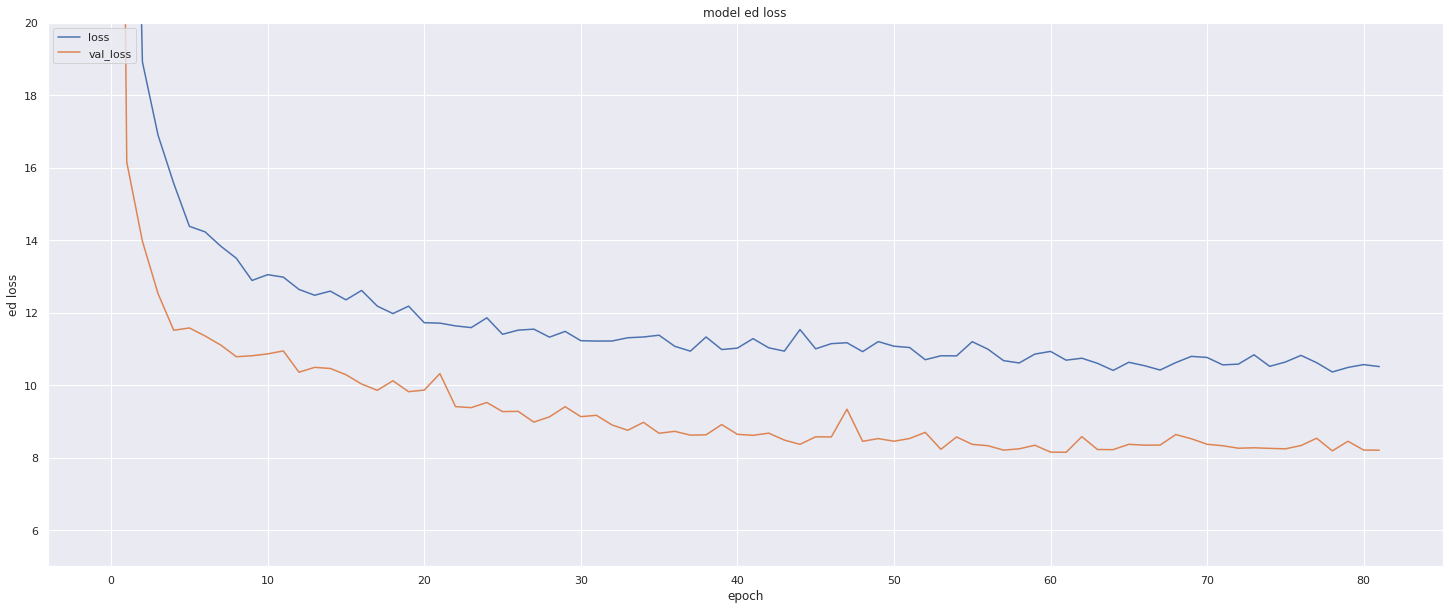

In [109]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe.history['loss'])
plt.plot(history_toe.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_tl.png', bbox_inches = 'tight')

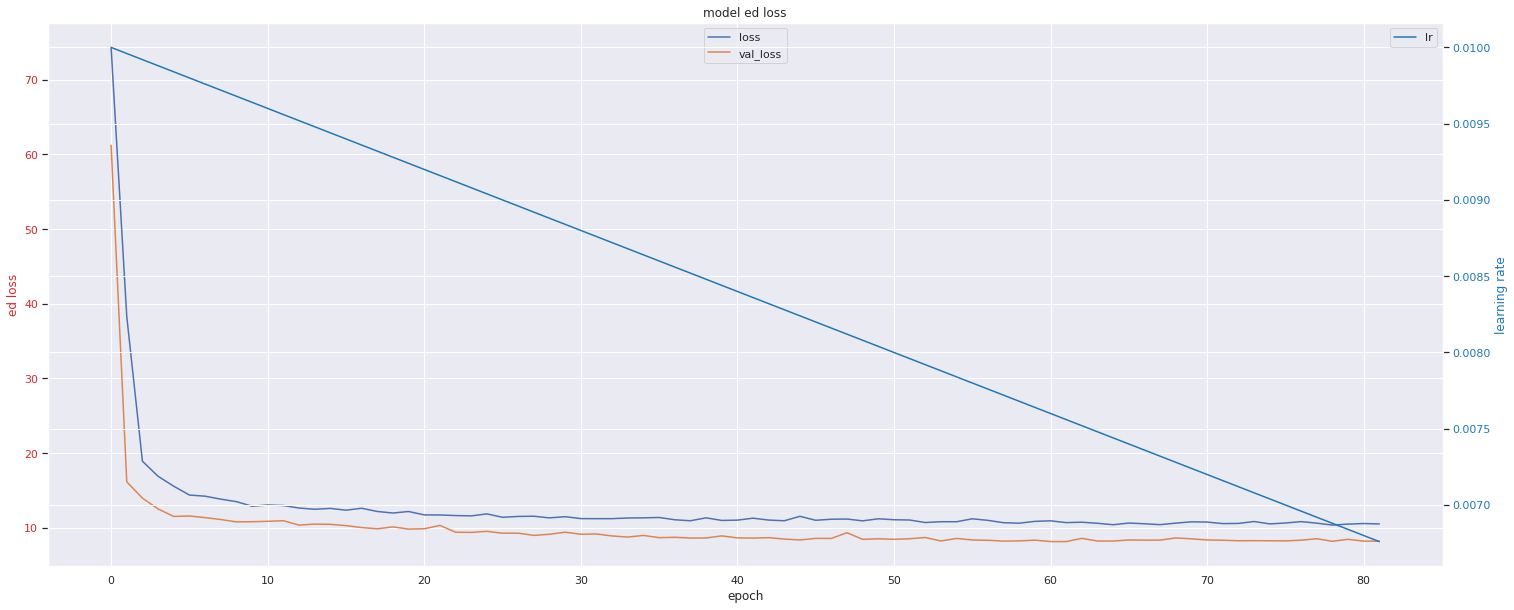

In [110]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe.history['loss'])
ax1.plot(history_toe.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()


# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

## Toe Fine-Tuning

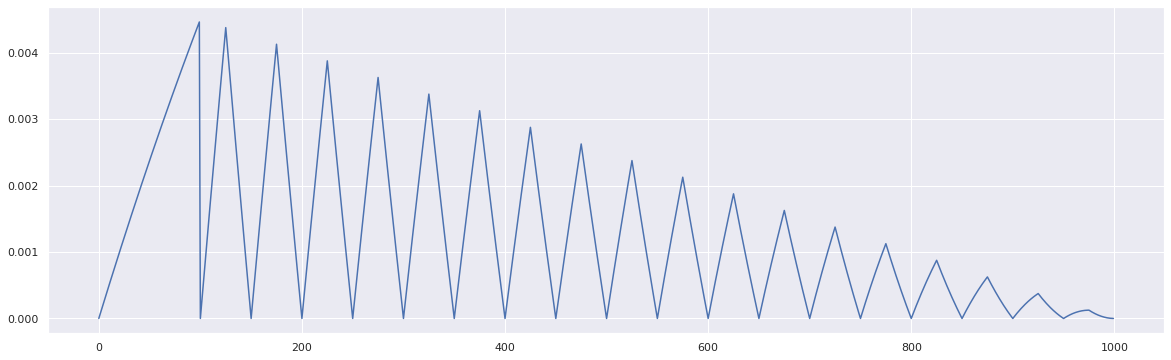

In [111]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [112]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [113]:
# """lr from kaggle leaf"""
# ep_num = 1000



# def lrfn2(epoch):
    
#     lr_start   = 0.000005
#     # lr_max     = 0.00000125 * strategy.num_replicas_in_sync * BATCH_SIZE
#     lr_max     = 0.001
#     lr_min     = 0.000001
#     lr_ramp_ep = 50
#     lr_sus_ep  = 20
#     lr_decay   = 0.95


#     if epoch < lr_ramp_ep:
#         lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#     elif epoch < lr_ramp_ep + lr_sus_ep:
#         lr = lr_max

#     else:
#         lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

#     return lr



# rng = [i for i in range(ep_num)]
# y = [lrfn2(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [114]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [115]:
def unfreeze_model(model, base_model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.





#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True


#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166 
#

    # Set All layers trainable first
    #model.trainable = True #範例似乎是指 base_model.trainable = True 而不是新建model！！！！！！(2021-11-08)
    base_model.trainable = True
    
    
    
    # Then, set layers NOT trainable below specific layer.
#     set_trainable = False
#     for layer in model.layers:
#         if layer.name == 'block5b_expand_conv': 
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [116]:
# unfreeze for finetune the toe model  
unfreeze_model(model_toe,base_model)

In [117]:
count_model_trainOrNot_layers(model_toe)

tt: 6, nt:0, total layers:6


In [118]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=500), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp
    PrintLRtoe()
]

In [119]:
%%time

# fit the model on all data
history_toe_finetune = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

Epoch 1/1000

[20211108-1143-58] Learning rate for epoch 1 is 4.999999987376214e-07
17/17 [==============================] - 35s 1s/step - loss: 10.6309 - val_loss: 8.1990

Epoch 00001: val_loss did not improve from 8.14628
Epoch 2/1000

[20211108-1144-33] Learning rate for epoch 2 is 5.044450517743826e-05
17/17 [==============================] - 1s 69ms/step - loss: 10.3066 - val_loss: 7.9917

Epoch 00002: val_loss improved from 8.14628 to 7.99168, saving model to ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 3/1000

[20211108-1144-35] Learning rate for epoch 3 is 0.00010028902033809572
17/17 [==============================] - 5s 314ms/step - loss: 10.2703 - val_loss: 7.6289

Epoch 00003: val_loss improved from 7.99168 to 7.62892, saving model to ./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 4/1000

[20211108-1144-41] Learning rate for epoch 4 is 0.00015003354928921908
17/17 [==============================] - 1s 69ms/step - loss: 9.8745 

    [20210225-1426-28] Learning rate for epoch 240 is 0.0016744130989536643
    Epoch 240/1000
    17/17 [==============================] - ETA: 0s - loss: 6.0727
    Epoch 00240: val_loss did not improve from 5.58202
    17/17 [==============================] - 1s 45ms/step - loss: 6.0727 - val_loss: 6.0411
    
    
    [2021-11-02 1504]  RTX 2080 Ti 
    速度慢約10ms/step但主要是噪音無法在辦公室訓練，寫好後開任務容器直接跑圖收結果回來。(註：任務容器仍沒有選用客製化映像檔的功能，對tf25odocr環境建立會很棘手！)
    RTX 2080 Ti Temp 63~66, GPU-util ~63% (風扇噪音與熱氣無法放辦公室使用)
    
    Epoch 00323: val_loss did not improve from 5.70558
    Epoch 324/1000

    [20211102-0757-50] Learning rate for epoch 324 is 0.003114226972684264
    17/17 [==============================] - 3s 55ms/step - loss: 6.2408 - val_loss: 6.4956
    
    #每次shuffle要固定種子 df.sample(frac=1, random_state=42).reset_index(drop=True)
    Epoch 00132: val_loss did not improve from 5.85424
    Epoch 133/1000

    [20211103-0047-39] Learning rate for epoch 133 is 0.0031249215826392174
    17/17 [==============================] - 1s 49ms/step - loss: 6.1173 - val_loss: 6.9323

    Epoch 00133: val_loss did not improve from 5.85424
    CPU times: user 2min 8s, sys: 5.38 s, total: 2min 13s
    Wall time: 2min 14s

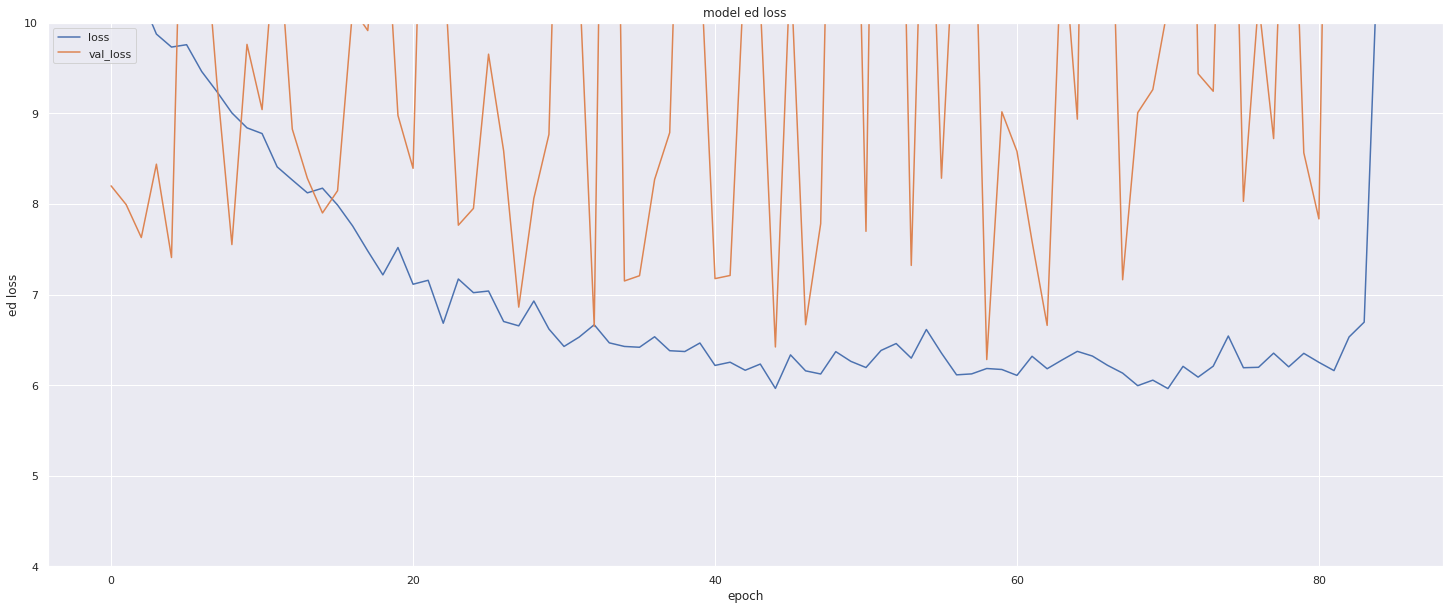

In [120]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe_finetune.history['loss'])
plt.plot(history_toe_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(4, 10)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_ft.png', bbox_inches = 'tight')

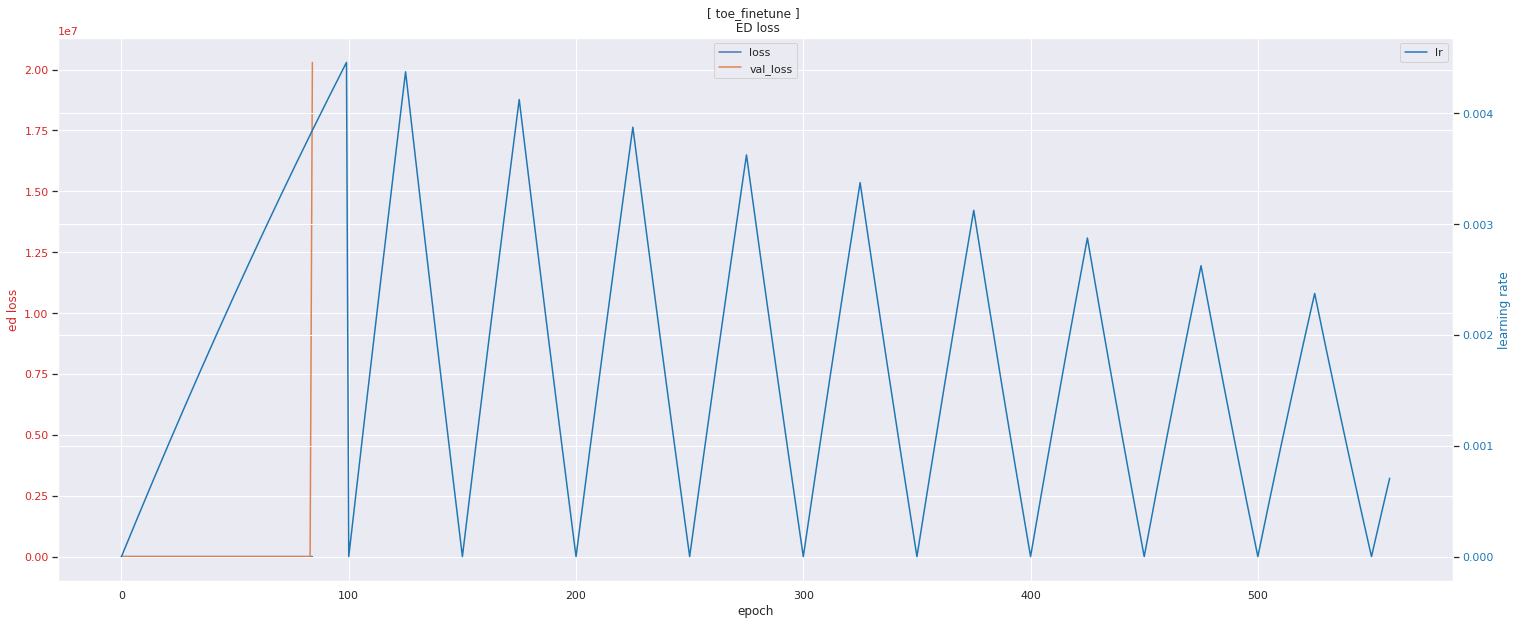

In [121]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe_finetune.history['loss'])
ax1.plot(history_toe_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [122]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])

vl, ep 

(nan, 85)

In [123]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_toe_finetune.history['val_loss'])

val_loss: nan at epoch 85.


In [124]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## Check the mean-Euclidean Distance of test data

may modify the ed-loss function

In [125]:
# # mean ed-loss == mean ed of test data.
# model_toe.evaluate(valid_ds_pre_toe_s)

In [126]:
# model_toe.evaluate(test_ds_pre_toe_s)
# model_heel.evaluate(test_ds_pre_heel_s)

# Heel 

### Transfer

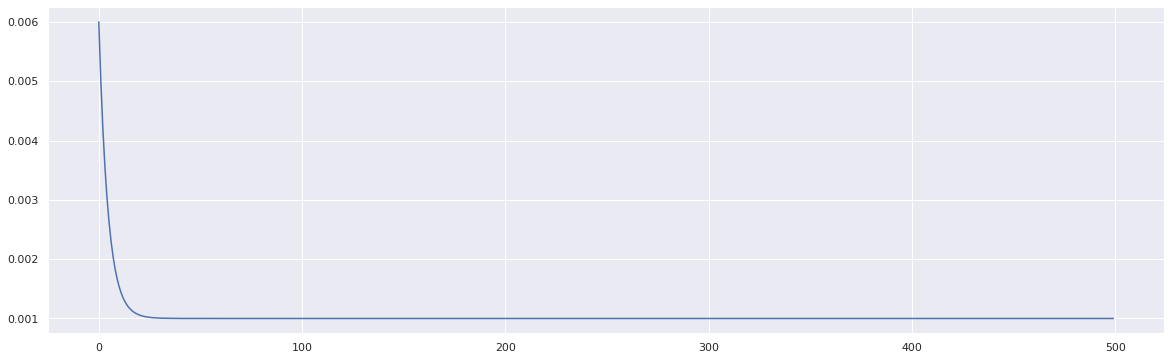

In [127]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 0
    lr_sus_ep  = 0
    lr_decay   = 0.8

    if lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [128]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.006


In [129]:
"""

"""
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
#                                                           factor=0.5, 
#                                                           patience=15, 
#                                                           verbose=1, 
#                                                           mode='auto', 
#                                                           #min_delta=0.0001, 
#                                                           cooldown=5, 
#                                                           #min_lr=1e-12
#                                                          )

'\n\n'

In [130]:
def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5
best_model_name: ./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5


In [131]:
logdir = log_dir_name + "/logs/heel/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [132]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=500), #patience=step_size ot ep_num
    tf.keras.callbacks.LearningRateScheduler(lrdump),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
#     lr_reduceonplateau,
    PrintLRheel()
]

In [133]:
# create Heel-tf model
top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
with strategy.scope():
    model_heel,base_model = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

base_model.trainable :  False


In [134]:
count_model_trainOrNot_layers(model_heel)

tt: 5, nt:1, total layers:6


In [135]:
%%time

# fit the model on all data
history_heel = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

Epoch 1/500
17/17 [==============================] - 13s 454ms/step - loss: 110.9733 - val_loss: 103.2294

Epoch 00001: val_loss improved from inf to 103.22940, saving model to ./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211108-1156-29] Learning rate for epoch 1 is 0.006000000052154064
Epoch 2/500
17/17 [==============================] - 0s 23ms/step - loss: 92.0946 - val_loss: 71.5861

Epoch 00002: val_loss improved from 103.22940 to 71.58607, saving model to ./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211108-1156-30] Learning rate for epoch 2 is 0.004999999888241291
Epoch 3/500
17/17 [==============================] - 4s 238ms/step - loss: 50.3521 - val_loss: 26.5469

Epoch 00003: val_loss improved from 71.58607 to 26.54693, saving model to ./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211108-1156-34] Learning rate for epoch 3 is 0.00419999985024333
Epoch 4/500
17/17 [==============================] - 0s 22ms/st

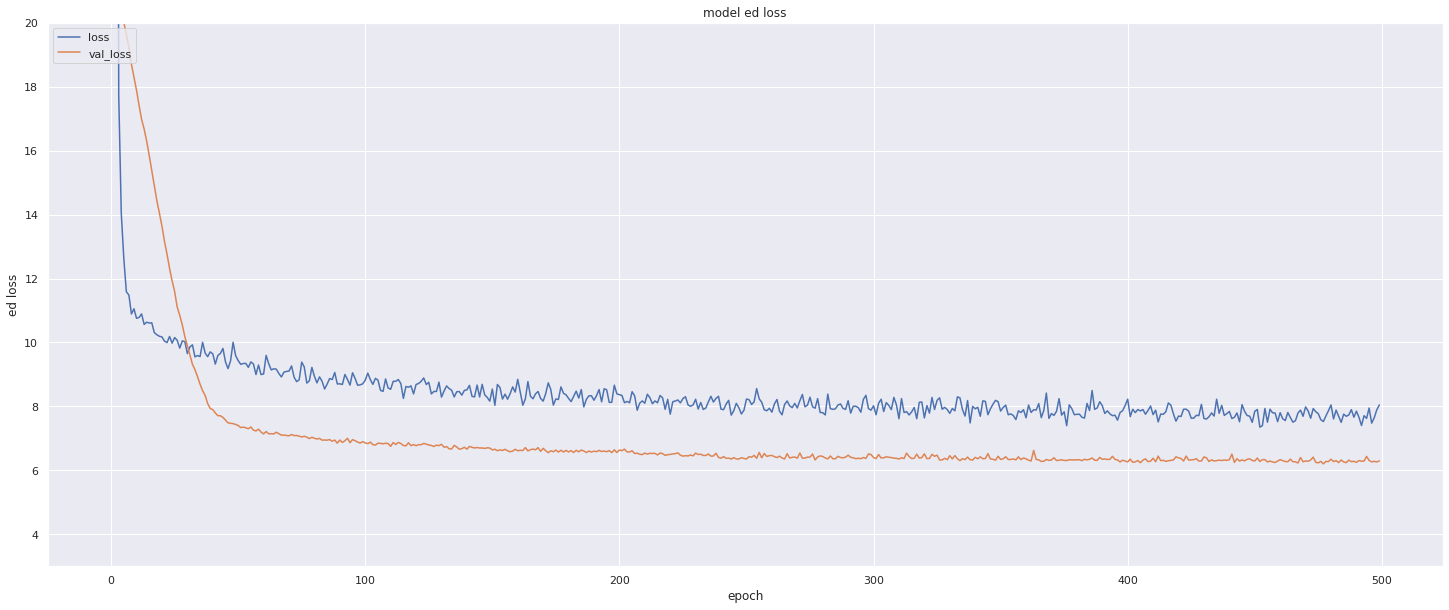

In [136]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel.history['loss'])
plt.plot(history_heel.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_tl', bbox_inches = 'tight')

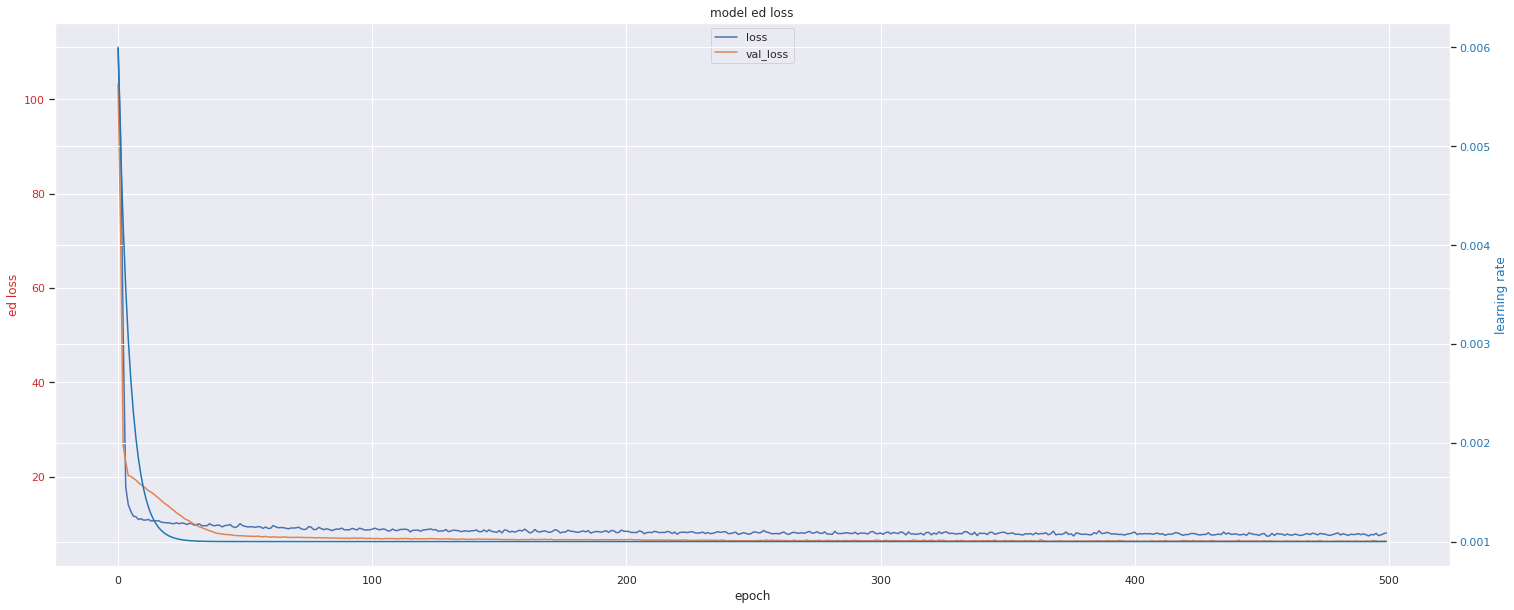

In [137]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_heel.history['loss'])
ax1.plot(history_heel.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [138]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])

vl, ep

(6.203851222991943, 477)

## Heel Fine-Tuning

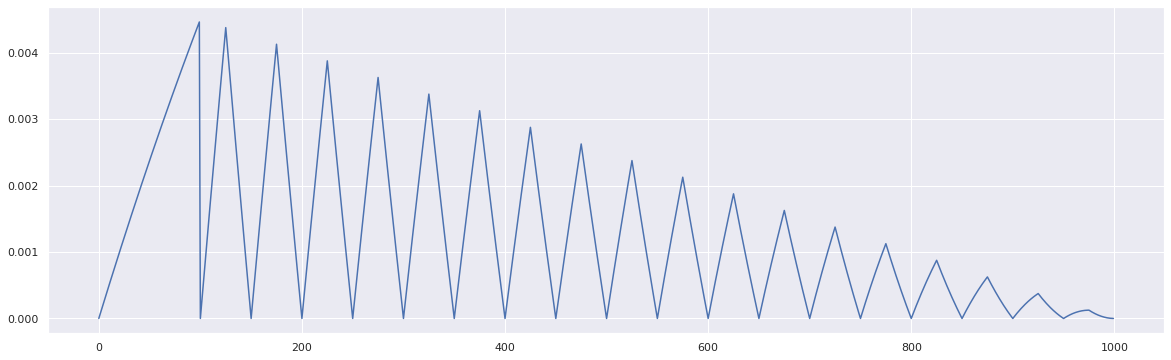

In [139]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7
    
#     step_size = 25 # currently best for foot pp
#     max_lr = 0.01 # currently best for foot pp
#     base_lr = 1e-8 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))# 1~20 range.
    x = np.abs(iterations/step_size - 2*cycle + 1) # 1~0,repeat 20 cycle.
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))

    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = base_lr + (((max_lr - base_lr) / lr_ramp_ep) * epoch)
    
#     # decay
#     if epoch > lr_ramp_ep:
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#         lr = lr * (base_part-decay)

    return lr * (base_part-decay) * lr_decay # supressed the lr! in fact, it will reduce new lr to 1/2 ratio.


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [140]:
# 4.999999999999993e-08 ~ 0.00891990901   # original lr with epoch decay.
# 2.4999999999999966e-08 ~ 0.004459954505 # supressed the lr!

In [141]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [142]:
# unfreeze for finetune the toe model  
unfreeze_model(model_heel,base_model)

In [143]:
count_model_trainOrNot_layers(model_heel)

tt: 6, nt:0, total layers:6


In [144]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=50), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr
    PrintLRheel()
]

In [145]:
%%time

# fit the model on all data
history_heel_finetune = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

Epoch 1/1000
17/17 [==============================] - 25s 1s/step - loss: 7.3238 - val_loss: 6.2489

Epoch 00001: val_loss did not improve from 6.20385

[20211108-1201-19] Learning rate for epoch 1 is 4.999999987376214e-07
Epoch 2/1000
17/17 [==============================] - 1s 72ms/step - loss: 7.3490 - val_loss: 6.7451

Epoch 00002: val_loss did not improve from 6.20385

[20211108-1201-20] Learning rate for epoch 2 is 5.044450517743826e-05
Epoch 3/1000
17/17 [==============================] - 5s 287ms/step - loss: 7.2283 - val_loss: 5.7577

Epoch 00003: val_loss improved from 6.20385 to 5.75770, saving model to ./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211108-1201-26] Learning rate for epoch 3 is 0.00010028902033809572
Epoch 4/1000
17/17 [==============================] - 1s 71ms/step - loss: 7.4042 - val_loss: 7.8235

Epoch 00004: val_loss did not improve from 5.75770

[20211108-1201-32] Learning rate for epoch 4 is 0.00015003354928921908
Epoch 5/1000
17/

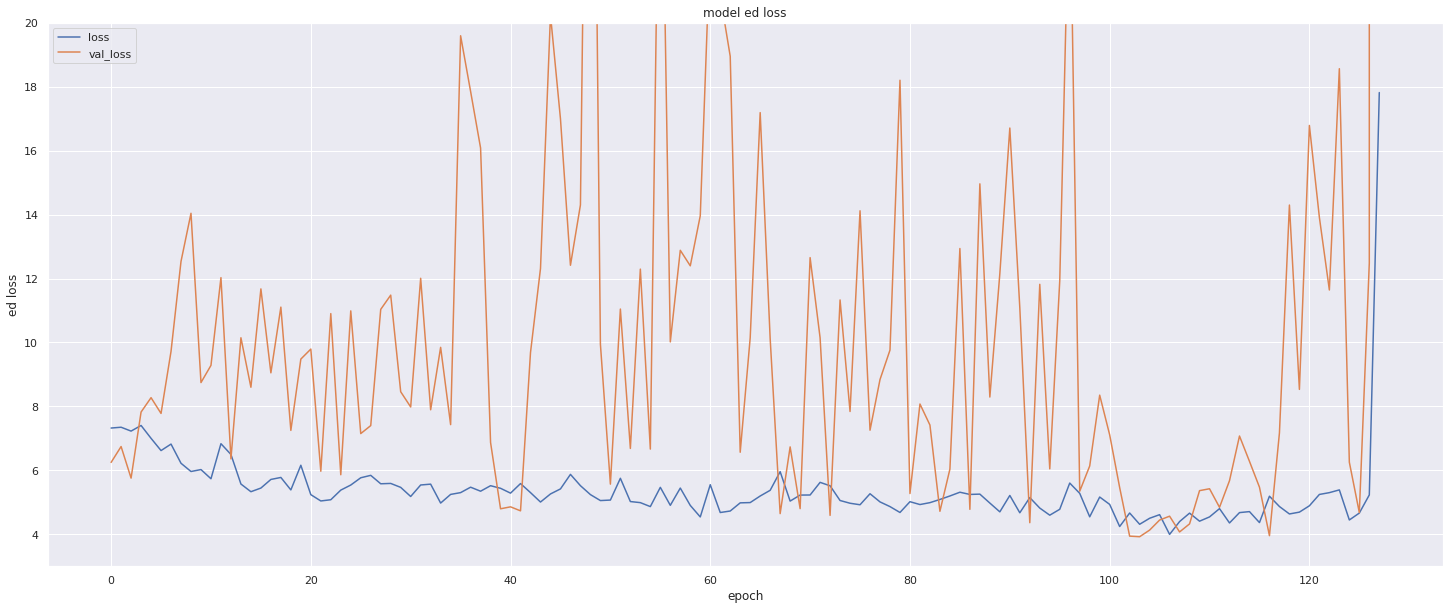

In [146]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel_finetune.history['loss'])
plt.plot(history_heel_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_ft.png', bbox_inches = 'tight')

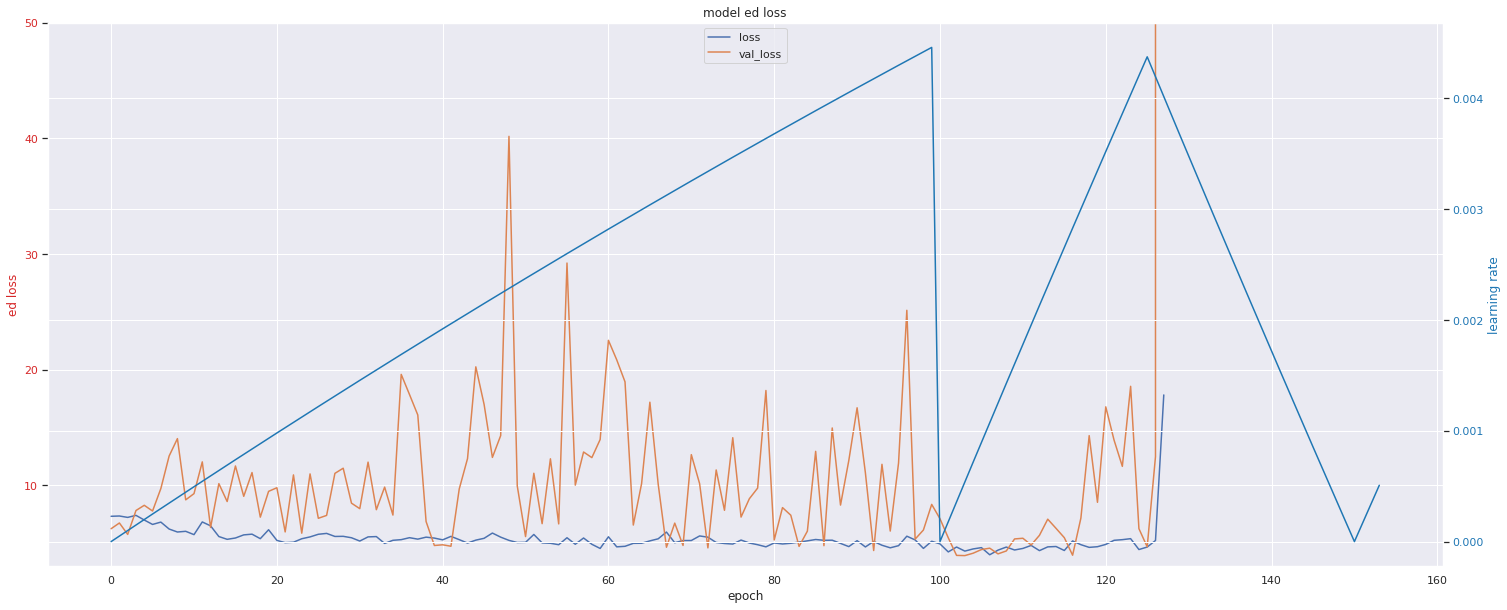

In [147]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color), ax1.set_ylim(3, 50)

ax1.plot(history_heel_finetune.history['loss'])
ax1.plot(history_heel_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [148]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])

In [149]:
vl, ep 

(nan, 128)

In [150]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_heel_finetune.history['val_loss'])

val_loss: nan at epoch 128.


In [151]:
# mean ed-loss == mean ed of test data.
model_heel.evaluate(valid_ds_pre_heel_s)

5/5 [==============================] - 0s 13ms/step - loss: nan


nan

In [152]:
# 這是最後模型去推論結果，不是中斷前的best model!

## Show predictions

In [153]:
# %%time
# # inference all val_ds
# predictions = model.predict(valid_ds_pre_toe_s)

In [154]:
# predictions.shape

In [155]:
# predictions[:5]

In [156]:
# %%time

# # inference bs by bs of val_ds #model.predict()#一次做完即可不用分batch
# image_batch, label_batch = valid_ds_pre_heel_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)

In [157]:
# image_batch.shape

In [158]:
# pred.shape

In [159]:
# pred[:5]

In [160]:
# label_batch[:5]

In [161]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [162]:
# neg[:5]

In [163]:
# neg.mean()#所有x,y平均

In [164]:
# neg.mean(axis=0)#所有x 所有y個別平均

In [165]:
# neg.mean(axis=1)#左x右y相加的平均

In [166]:
# np.median(neg)#中位數

In [167]:
# neg.min(axis=0)

In [168]:
# neg.max(axis=0)

In [169]:
# model.metrics_names

## show pp pred

* we can switch toe/hell by comment it

### Baseline Simple2D model

In [170]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [171]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# # pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=4)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=4)

### EFN Toe

In [172]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [173]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_toe.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [174]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [175]:
# np.abs(neg)[:5]

In [176]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [177]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [178]:
# # it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [179]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# # image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_heel.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [180]:
# pred[:5]

In [181]:
# label_batch[:5]

In [182]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [183]:
# np.abs(neg)[:10]

In [184]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [185]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [186]:
ts = 'test_submission.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)

,images,x1,y1,x2,y2
0,image_0001.png,NaN,NaN,NaN,NaN
1,image_0002.png,NaN,NaN,NaN,NaN
2,image_0003.png,NaN,NaN,NaN,NaN
3,image_0004.png,NaN,NaN,NaN,NaN
4,image_0005.png,NaN,NaN,NaN,NaN


In [187]:
df_ts['images']

0      image_0001.png
1      image_0002.png
2      image_0003.png
3      image_0004.png
4      image_0005.png
            ...      
995    image_0996.png
996    image_0997.png
997    image_0998.png
998    image_0999.png
999    image_1000.png
Name: images, Length: 1000, dtype: object

In [188]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [189]:
len(list_ds_test)#.shape() #take(1)

1000

In [190]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [191]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

take test sample: b'image_0001.png'
take test sample: b'image_0002.png'
take test sample: b'image_0003.png'
take test sample: b'image_0004.png'
take test sample: b'image_0005.png'


### TEST DS: Process TEST path to image tensor

In [192]:
## TEST-DS: re-used from train/val-ds

im_test = 'test_images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [193]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [194]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

take sample: (120, 120, 3) b'image_0001.png'
take sample: (120, 120, 3) b'image_0002.png'
take sample: (120, 120, 3) b'image_0003.png'
take sample: (120, 120, 3) b'image_0004.png'
take sample: (120, 120, 3) b'image_0005.png'


### prepare TEST_ds_pre

In [195]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [196]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

Check cache in memory:Y True
Check cache in memory:Y True


## Predict test (abandon)

### Toe model

In [197]:
# model_toe

In [198]:
# %%time
# # inference all test_ds once
# predictions_toe = model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

In [199]:
# predictions_toe

### Offset Toe

In [200]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe
# predictions_toe

### Heel model

In [201]:
# %%time
# # inference all test_ds once
# predictions_heel = model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

In [202]:
# predictions_heel

### Offset Heel

In [203]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel
# predictions_heel

### Merge toe/hell pred

In [204]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [205]:
# predictions_th.shape

In [206]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [207]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [208]:
# predictions_merge.take(0)

In [209]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [210]:
# df_submission.head(5)

In [211]:
# df_submission.to_csv('submission.csv', index=False)

# Load Best-model

In [212]:
# if models are in last time frame
best_model_toe_name = get_best_model_name('toe')
best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




print(best_model_toe_name)
print(best_model_heel_name)
# log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)

./20211108-114239/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
./20211108-114239/heel_EfficientNetB0_bs64_w120_best_val_loss.h5


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [213]:
best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [214]:
%%time
# inference all test_ds once
predictions_toe = best_model_toe.predict(test_ds_pre_toe)
predictions_toe.shape

CPU times: user 4.2 s, sys: 454 ms, total: 4.66 s
Wall time: 7.89 s


(1000, 2)

### Offset Toe

In [215]:
predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# for [0,1]
# predictions_toe[:,0] = predictions_toe[:,0]*120
# predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # for [-1,1]
# # for re-scale back xy 
# # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

predictions_toe

array([[ 58.90515 , 138.32057 ],
       [ 58.261395, 143.88019 ],
       [ 53.02027 , 143.81023 ],
       ...,
       [ 63.236866, 134.63263 ],
       [ 63.678288, 121.32419 ],
       [ 58.648785, 122.85119 ]], dtype=float32)

In [216]:
%%time
# inference all test_ds once
predictions_heel = best_model_heel.predict(test_ds_pre_heel)
predictions_heel.shape

CPU times: user 2.78 s, sys: 134 ms, total: 2.91 s
Wall time: 2.24 s


(1000, 2)

### Offset Heel

In [217]:
predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# for [0,1]
# predictions_heel[:,0] = predictions_heel[:,0]*120
# predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # for [-1,1]
# predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

predictions_heel

array([[ 81.335495, 380.88596 ],
       [ 22.989918, 378.11273 ],
       [ 79.12385 , 385.1309  ],
       ...,
       [ 28.92156 , 382.90662 ],
       [ 75.211914, 382.5323  ],
       [ 35.86741 , 382.8789  ]], dtype=float32)

### Merge toe/hell pred

In [218]:
predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
predictions_th.shape

(1000, 4)

In [219]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

(1000, 1)

In [220]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

(1000, 5)

In [221]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [222]:
#fixed random_state rs 42
submi_name = log_dir_name + '/PT_' + log_dir_name + '_rs42_noAug_df1345_' +'.csv'

# submi_name = '0000_ft_' + log_dir_name +'.csv'
# submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))

Save 20211108-114239/PT_20211108-114239_rs42_noAug_df1345_.csv as submission CSV.


    2021-11-03
    重新用無aug訓練結果
    
    0000_ft_20211103-033949.csv 
    ED 5.47334 + 3.55069 = 9.02404 LB 9.4121266 
    
    * 比較1424/1345 noAug對LB差異
    * 證實：使用不刪減標註錯誤的原始資料集，在noAug，相同random_state=42下train/val相同下，具有比資料清洗後更高的LB。這差距應該差不多是當初privte LB 1st的差距(8.1914 <-- 8.3141)。
    20211103-140936/PT_20211103-140936_rs42_noAug_df1345_.csv 
    ED 5.81324 + 3.66716 = 9.4804 LB: 9.3162689
    
    20211103-143247/PT_20211103-143247_rs42_noAug_df1424_.csv (** df1424並未開啟)
    ED:5.73402 + 3.46492 = 9.19894 LB: 9.1828668
    
    
    
    [EfficientNetB0]
    2021-11-05 上面df1424並未開啟
        20211105-101047/PT_20211105-101047_rs42_noAug_df1424_.csv
        ED:6.09531 + 3.5876 = 9.68291 LB: 9.7025955 更差了
        ED:6.25209 + 3.4496 = 9.70169 ??重跑更加差
        ED:6.34336 + 3.52755 = 9.87091 WTF??
        ED:6.0768 + 3.60764 = 9.68444
        ED:6.24145 + 3.37453 = 9.61598
            訓練不穩定！！之前也有過，不清楚原因。
        ED:6.37047 + 3.674 = 10.04447
        
        %reset -f 清除 IPython 中的所有變數 + run: Restart kernal and run all cells
        ED:6.46048 + 3.53942 = 9.9999
        ED:6.21367 + 3.55884 = 9.77251
        ED:6.26749 + 3.65374 = 9.92124 LB: 9.9827463
        
        

        
        
        切回df1345 驗證看看_rs42_noAug_df1345
        ED:5.87471 + 3.55093 = 9.42564
        ED:5.67823 + 3.61991 = 9.29813
        ED:5.75891 + 3.45725 = 9.21615 LB: 9.3887453
        Best model's ed of :  EfficientNetB0 WallTime:  537.3011837955564
        val ED:5.97359 + 3.58608 = 9.55967
        Test ED:6.23453 + 3.67103 = 9.90556
        
        
     貌似120太小，使用複雜的模型反而在虛空漫遊似的，找不到最小值。可以嘗試簡化的模型來驗證。   
    
    [B7]
     val ED:6.066 + 3.74753 = 9.81353
    Test ED:6.48869 + 3.78462 = 10.27331
    
    
    
    [Xception]
        28mins
        val ED:5.99453 + 4.6716 = 10.66613
        Test ED:6.29403 + 4.49941 = 10.79345

    [VGG] not work, kill at first epoch!!!
    
    
    [2021-11-07] (1)Test W/WO Aug. (2) model.trainable=True. (3)Test tl with training=false. (With 1345)
    [2021-11-08]
    
        [B0] org, test/val only, noAug
        Best model's ed of :  EfficientNetB0 WallTime:  983.4519834686071 16.4min
            val ED:5.98883 + 3.46494 = 9.45377
            Test ED:5.98883 + 3.46494 = 9.45377
        Best model's ed of :  EfficientNetB0 WallTime:  588.9569533187896 10.0min
            val ED:5.79862 + 3.54382 = 9.34244
            Test ED:5.79862 + 3.54382 = 9.34244
            
        [B0] org, test/val only, Aug
        Best model's ed of :  EfficientNetB0 WallTime:  2204.2603075709194 36.7min (增加3.5倍時間 僅進步0.05)
            val ED:5.71393 + 3.58175 = 9.29568
            Test ED:5.71393 + 3.58175 = 9.29568
            
            
            
        [B0] org, test/val only, noAug, model.trainable = True (All trainable)
            Best model's ed of :  EfficientNetB0 WallTime:  1071.7707716338336 17.8min
            val ED:5.52118 + 3.53973 = 9.0609
        again>
            Best model's ed of :  EfficientNetB0 WallTime:  1188.2662735395133 19.8min
            val ED:5.56375 + 3.69408 = 9.25783 (波動太大 無法判斷原因參數)

            
        [B0] org, test/val only, Aug, model.trainable = True (All trainable)
            Best model's ed of :  EfficientNetB0 WallTime:  2785.3764121886343 46.4min
            val ED:5.66877 + 3.48313 = 9.1519
        
        
        2021-11-08
        [B0] org, test/val only, noAug, model.trainable = True (All trainable), base_model(inputs, training=False)
        
            Best model's ed of :  EfficientNetB0 WallTime:  703.145051214844
            val ED:6.71756 + 3.76926 = 10.48682
        
        
        [B0] org, test/val only, noAug, model.trainable = True (All trainable), base_model(inputs, training=False) + base_model.trainable = True
            Best model's ed of :  EfficientNetB0 WallTime:  1004.5159711875021
                val ED:nan + nan = nan
                Test ED:6.0725 + 3.86312 = 9.93562
            Best model's ed of :  EfficientNetB0 WallTime:  644.9851351082325
                val ED:nan + 4.6183 = nan
                Test ED:6.15291 + 4.6183 = 10.77121
                可能lr太高造成波動 train loss正常 僅有val_loss波動太大
            
            Best model's ed of :  EfficientNetB0 WallTime:  1367.7790193650872
                val ED:nan + nan = nan
                Test ED:6.28165 + 3.92489 = 10.20654 (提高patient=500 無幫助)
        
        
        
        
        

        2021-11-06
        (more big model seems get poor ED)
        [B3] org, test/val only, Aug
        Best model's ed of :  EfficientNetB3 WallTime:  2694.7197468113154 44.9min (更糟)
        val ED:6.26896 + 3.82674 = 10.0957

        [B3] org, test/val only, noAug, model.trainable = True (All trainable)
        Best model's ed of :  EfficientNetB3 WallTime:  1300.486620305106 21.6min
            val ED:5.66297 + 4.02383 = 9.6868

    
    
    d
    
**bold size text**   <br>
new line <br>

In [223]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [224]:
df_submission.head()

,images,x1,y1,x2,y2
0,image_0001.png,58.905151,138.320572,81.335495,380.885956
1,image_0002.png,58.261395,143.880188,22.989918,378.112732
2,image_0003.png,53.020271,143.810226,79.123848,385.13089
3,image_0004.png,55.817982,138.120834,27.275997,373.748199
4,image_0005.png,61.382179,145.735718,69.582222,371.164703


In [225]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

print(f'val ED:{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

val ED:nan + nan = nan


#### mED of test dataset

In [226]:
# # mean ed-loss == mean ed of test data.

# TVT split of TEST
# toe_ed_test = best_model_toe.evaluate(test_ds_pre_toe_s)
# heeo_ed_test = best_model_heel.evaluate(test_ds_pre_heel_s)
# print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

# train/val , test same as val
toe_ed_test = best_model_toe.evaluate(valid_ds_pre_toe_s)
heeo_ed_test = best_model_heel.evaluate(valid_ds_pre_heel_s)
print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

5/5 [==============================] - 4s 475ms/step - loss: 3.9249
Test ED:6.28165 + 3.92489 = 10.20654


In [227]:
# Timing

print("Best model's ed of : ", model_name, "WallTime: ", t.tocvalue() )
print(f'val ED:{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

Best model's ed of :  EfficientNetB0 WallTime:  1367.7790193650872
val ED:nan + nan = nan
Test ED:6.28165 + 3.92489 = 10.20654


In [228]:
# the final timer of nb
!date

Mon Nov  8 12:05:19 CST 2021


In [229]:
# from pytictoc import TicToc

# t = TicToc() #create instance of class

# t.tic() #Start time
# time.sleep(1)

t.toc() #Time elapsed since t.tic()

Elapsed time is 1368.448440 seconds.


In [230]:
#大約11分鐘跑完

In [231]:
#

## save model

In [232]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/



### 